Actual bands in Predicted FC file: 3
Actual bands in Reference FC file: 3
Predicted Raster Resolution: 0.004162008945839627m x 0.004162008945839627m
Reference Raster Resolution: 0.004697m x 0.004697m
Predicted Raster CRS: WGS 84
Reference Raster CRS: WGS 84

Ensuring reference raster is perfectly aligned to predicted raster's grid (this may create a temporary file)...
Resampling FC.8day.v310.MCD43A4.A20250101.aust.061.tif to match target grid (extent, resolution, CRS)...
Resampling complete. Output saved to: C:\Users\ilyas\Dropbox\Jobs\RA_USQ\MODIS_FC\Accuracy_Reports\FC.8day.v310.MCD43A4.A20250101.aust.061_ALIGNED_TO_PREDICTED.tif
  Actual warped output dimensions: 2107x2302
  Target dimensions for warp: 2107x2302
Sampling 1500000 pixels from FC_Combined.v310.20250103.tif for analysis...
Sampling 1500000 pixels from FC.8day.v310.MCD43A4.A20250101.aust.061_ALIGNED_TO_PREDICTED.tif for analysis...

--- Accuracy Assessment Results (based on sampled data) ---

Band: Bare Soil
  MAE: 9.38 

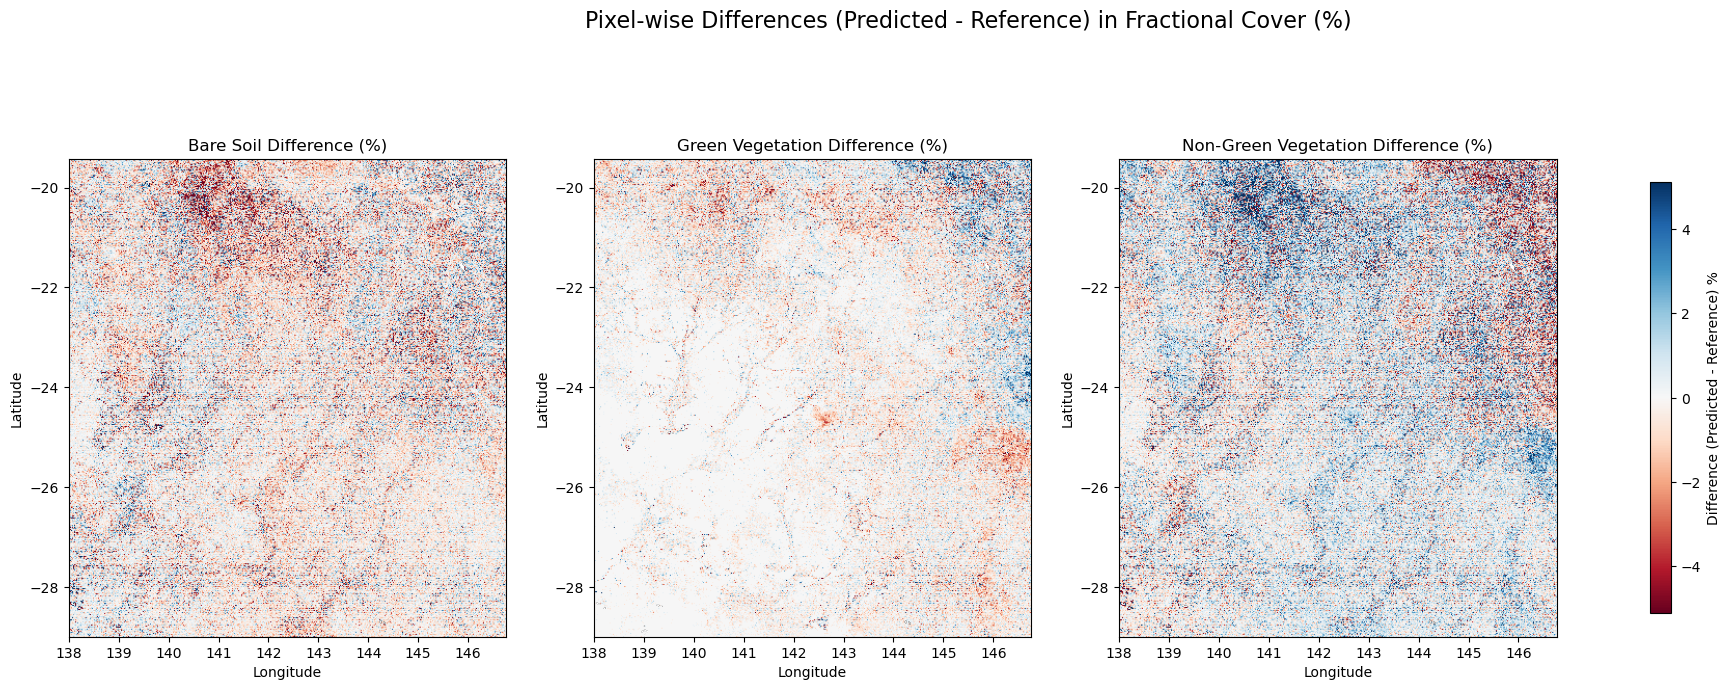


--- Generating Histograms of Differences ---
  Histogram saved to: C:\Users\ilyas\Dropbox\Jobs\RA_USQ\MODIS_FC\Accuracy_Reports\bare_soil_histogram_of_differencesTDCG4.jpg


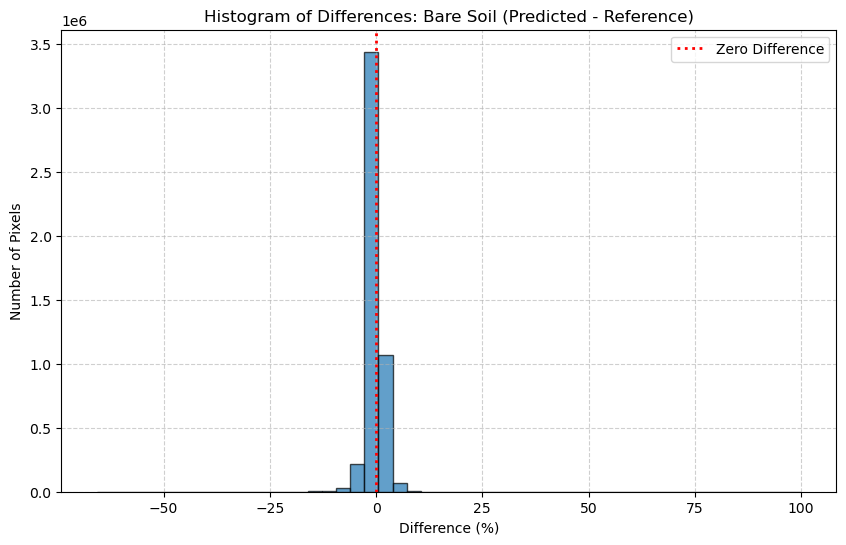

  Histogram saved to: C:\Users\ilyas\Dropbox\Jobs\RA_USQ\MODIS_FC\Accuracy_Reports\green_vegetation_histogram_of_differencesTDCG4.jpg


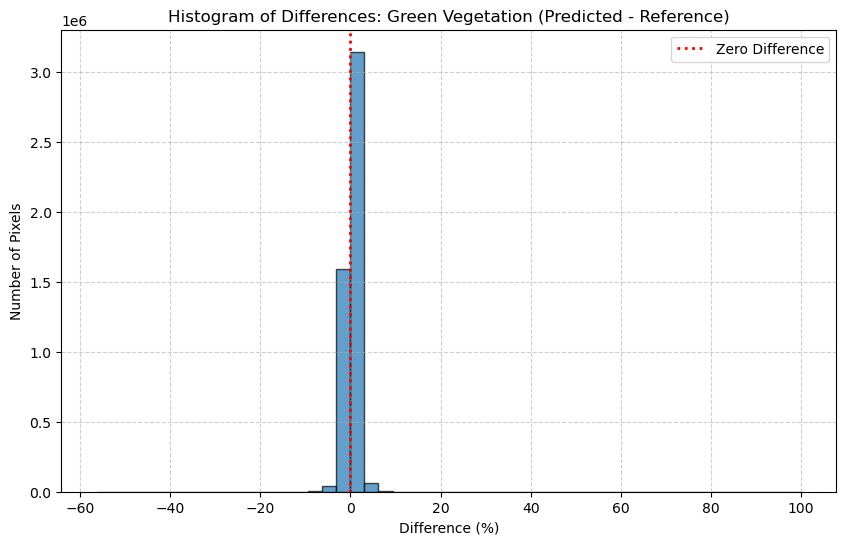

  Histogram saved to: C:\Users\ilyas\Dropbox\Jobs\RA_USQ\MODIS_FC\Accuracy_Reports\non-green_vegetation_histogram_of_differencesTDCG4.jpg


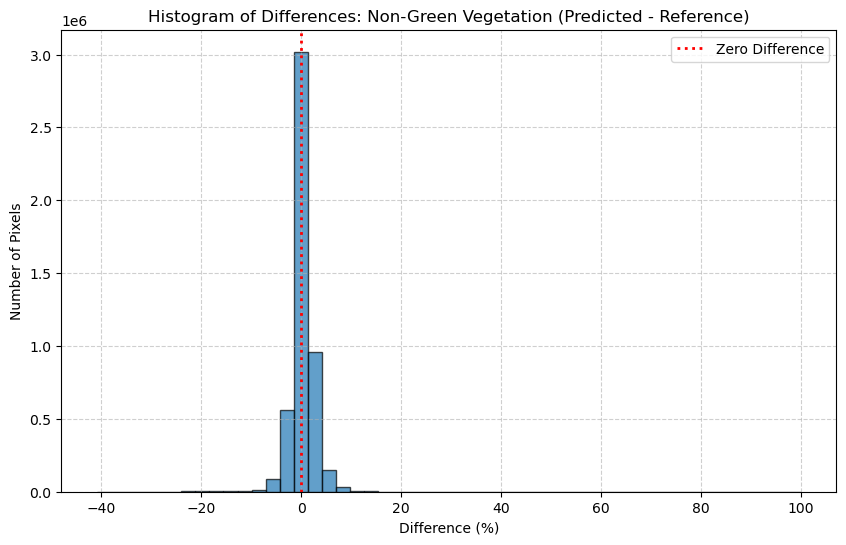


Cleaning up temporary file: C:\Users\ilyas\Dropbox\Jobs\RA_USQ\MODIS_FC\Accuracy_Reports\FC.8day.v310.MCD43A4.A20250101.aust.061_ALIGNED_TO_PREDICTED.tif

Script finished. All plots saved as JPGs. Metrics printed above for manual copy.


In [2]:
import numpy as np
from osgeo import gdal, osr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import pandas as pd # Still useful for organizing metrics before printing, even if not exporting to CSV
import sys
import traceback

# Enable GDAL exceptions for more detailed error messages
gdal.UseExceptions()

# --- Configuration ---
# IMPORTANT: For best results with Lat/Lon frames, ensure PREDICTED_FC_PATH is already in EPSG:4326 (WGS 84)
PREDICTED_FC_PATH = r"C:\Users\ilyas\Dropbox\Jobs\RA_USQ\MODIS_FC\fractional_cover_output\20250103\FC_Combined.v310.20250103.tif"
REFERENCE_FC_PATH = r"C:\Users\ilyas\Dropbox\Jobs\RA_USQ\MODIS_FC\Validation\FC.8day.v310.MCD43A4.A20250101.aust.061.tif"

# Define the NoData value used in your GeoTIFFs
NODATA_VALUE = 255 # Assuming 255 for your Byte output

# Configuration for sampling (for statistical analysis)
SAMPLE_PIXEL_COUNT = 1500000 # Number of random pixels to sample for statistics
SAMPLE_FOR_PLOT_SCALE = 100000 # Number of random pixels to sample for plot color scaling (smaller for large images)

# Configuration for block processing (for difference map)
BLOCK_SIZE = 512 # Size of the square block (e.g., 512x512 pixels)

# Output directory for accuracy reports (CSV and JPGs)
ACCURACY_OUTPUT_DIR = r"C:\Users\ilyas\Dropbox\Jobs\RA_USQ\MODIS_FC\Accuracy_Reports" 
os.makedirs(ACCURACY_OUTPUT_DIR, exist_ok=True) # Ensure output directory exists

# --- Plotting Optimization Parameters ---
PLOT_DPI = 150 # Reduced DPI for saving plots to reduce memory usage
PLOT_DOWNSAMPLE_FACTOR = 5 # Take every Nth pixel for plotting to reduce memory (e.g., 5 means 1/25th data)

# --- Helper Functions ---

def read_raster_metadata(file_path):
    """
    Reads only metadata (geotransform, projection, sizes, band count) from a raster.
    Does NOT load pixel data into memory.
    Returns (geotransform, projection, xsize, ysize, num_bands)
    """
    try:
        ds = gdal.Open(file_path, gdal.GA_ReadOnly)
        if ds is None:
            print(f"Error: Could not open file for metadata: {file_path}")
            return None, None, None, None, None # Return None for all if file cannot be opened
        num_bands = ds.RasterCount
        xsize = ds.RasterXSize
        ysize = ds.RasterYSize
        geotransform = ds.GetGeoTransform()
        projection = ds.GetProjection()
        
        del ds # Close the dataset
        return geotransform, projection, xsize, ysize, num_bands
    except Exception as e:
        print(f"Error reading metadata from {file_path}: {e}")
        return None, None, None, None, None

def read_raster_band_block(file_path, band_num, xoff, yoff, xsize, ysize, nodata_value=None):
    """
    Reads a block of data from a single band of a raster.
    """
    ds = gdal.Open(file_path, gdal.GA_ReadOnly)
    if ds is None:
        raise FileNotFoundError(f"Could not open file: {file_path}")
    
    band = ds.GetRasterBand(band_num)
    block_data = band.ReadAsArray(xoff, yoff, xsize, ysize).astype(np.float32)
    
    if nodata_value is not None:
        block_data[block_data == nodata_value] = np.nan
        
    del ds
    return block_data

def get_sampled_data_for_analysis(file_path, num_bands_to_read, xsize, ysize, sample_count, nodata_value=None):
    """
    Reads a random sample of pixels from a multi-band raster for statistical analysis.
    This version reads entire bands into memory for faster sampling, assuming memory allows.
    If rasters are extremely large, a block-based sampling approach would be needed.
    """
    if file_path is None:
        print("Error: Input file_path for sampling is None. Cannot proceed.")
        return None
        
    # print(f"Sampling {sample_count} pixels from {os.path.basename(file_path)} for analysis...") # Removed for less verbose output
    
    ds = gdal.Open(file_path, gdal.GA_ReadOnly)
    if ds is None:
        print(f"Error: Could not open file for sampling: {file_path}")
        return None

    actual_num_bands_in_file = ds.RasterCount
    if num_bands_to_read > actual_num_bands_in_file:
        print(f"Warning: Requested to read {num_bands_to_read} bands from {os.path.basename(file_path)}, but file only has {actual_num_bands_in_file} bands. Reading {actual_num_bands_in_file} bands instead.")
        num_bands_to_read = actual_num_bands_in_file

    sampled_data = np.zeros((num_bands_to_read, sample_count), dtype=np.float32)

    for i in range(num_bands_to_read):
        band = ds.GetRasterBand(i + 1)
        band_data = band.ReadAsArray().astype(np.float32)
        
        if nodata_value is not None:
            band_data[band_data == nodata_value] = np.nan
        
        flat_band_data = band_data.flatten()
        valid_pixels = flat_band_data[~np.isnan(flat_band_data)]
        
        if len(valid_pixels) == 0:
            print(f"Warning: No valid pixels found in band {i+1} of {os.path.basename(file_path)}. Skipping sampling for this band.")
            sampled_data[i, :] = np.nan
            continue

        current_sample_count = min(sample_count, len(valid_pixels))
        sampled_values = np.random.choice(valid_pixels, size=current_sample_count, replace=False)
        
        if current_sample_count < sample_count:
            padded_values = np.full(sample_count, np.nan, dtype=np.float32)
            padded_values[:current_sample_count] = sampled_values
            sampled_data[i, :] = padded_values
        else:
            sampled_data[i, :] = sampled_values

    del ds
    return sampled_data


def resample_raster_to_target_grid(input_raster_path, target_raster_metadata, output_raster_path, resampling_method=gdal.GRA_Average):
    """
    Resamples an input raster to precisely match the resolution, extent, and projection
    of a target raster (provided as metadata tuple) using gdal.Warp.
    This function is now designed to ensure perfect alignment, including pixel dimensions.
    """
    if not os.path.exists(input_raster_path):
        print(f"Error: Input raster for resampling not found: {input_raster_path}")
        return None

    target_gt, target_proj, target_xsize, target_ysize, _ = target_raster_metadata
    if any(x is None for x in [target_gt, target_proj, target_xsize, target_ysize]):
        print(f"Error: Invalid target raster metadata provided for resampling.")
        return None

    print(f"Resampling {os.path.basename(input_raster_path)} to match target grid (extent, resolution, CRS)...")
    
    minX = target_gt[0]
    maxY = target_gt[3]
    maxX = target_gt[0] + target_xsize * target_gt[1]
    minY = target_gt[3] + target_ysize * target_gt[5] 
    
    try:
        warp_options = gdal.WarpOptions(
            format="GTiff",
            resampleAlg=resampling_method,
            xRes=target_gt[1], 
            yRes=abs(target_gt[5]), 
            outputBounds=(minX, minY, maxX, maxY), 
            dstSRS=target_proj, 
            srcNodata=NODATA_VALUE, 
            dstNodata=NODATA_VALUE,
            width=target_xsize, # Explicitly set output dimensions
            height=target_ysize  # Explicitly set output dimensions
        )

        gdal.Warp(
            output_raster_path,
            input_raster_path,
            options=warp_options 
        )
        print(f"Resampling complete. Output saved to: {output_raster_path}")
        
        ds_warped_check = gdal.Open(output_raster_path, gdal.GA_ReadOnly)
        if ds_warped_check:
            print(f"  Actual warped output dimensions: {ds_warped_check.RasterXSize}x{ds_warped_check.RasterYSize}")
            print(f"  Target dimensions for warp: {target_xsize}x{target_ysize}")
            del ds_warped_check
        
        return output_raster_path
    except Exception as e:
        print(f"Error during resampling: {e}")
        traceback.print_exc() # Print traceback for debugging
        return None

# --- Main Analysis Function ---
def run_accuracy_analysis():
    all_metrics_data = [] 
    temp_aligned_reference_path = None # To track the perfectly aligned reference file

    try:
        # --- Step 1: Read metadata for both rasters ---
        pred_gt, pred_proj, pred_xsize, pred_ysize, pred_num_bands = read_raster_metadata(PREDICTED_FC_PATH)
        if any(x is None for x in [pred_gt, pred_proj, pred_xsize, pred_ysize, pred_num_bands]):
            print(f"Error: Could not read metadata from predicted raster: {PREDICTED_FC_PATH}. Exiting.")
            return

        ref_gt, ref_proj, ref_xsize, ref_ysize, ref_num_bands = read_raster_metadata(REFERENCE_FC_PATH)
        if any(x is None for x in [ref_gt, ref_proj, ref_xsize, ref_ysize, ref_num_bands]):
            print(f"Error: Could not read metadata from reference raster: {REFERENCE_FC_PATH}. Exiting.")
            return

        print(f"Actual bands in Predicted FC file: {pred_num_bands}")
        print(f"Actual bands in Reference FC file: {ref_num_bands}")

        pred_res_x = abs(pred_gt[1])
        pred_res_y = abs(pred_gt[5])
        ref_res_x = abs(ref_gt[1])
        ref_res_y = abs(ref_gt[5])

        print(f"Predicted Raster Resolution: {pred_res_x}m x {pred_res_y}m")
        print(f"Reference Raster Resolution: {ref_res_x}m x {ref_res_y}m")
        
        pred_srs = osr.SpatialReference()
        pred_srs.ImportFromWkt(pred_proj)
        ref_srs = osr.SpatialReference()
        ref_srs.ImportFromWkt(ref_proj)

        print(f"Predicted Raster CRS: {pred_srs.GetAttrValue('PROJCS') or pred_srs.GetAttrValue('GEOGCS')}")
        print(f"Reference Raster CRS: {ref_srs.GetAttrValue('PROJCS') or ref_srs.GetAttrValue('GEOGCS')}")

        # --- IMPORTANT: Ensure reference raster is perfectly aligned to predicted raster's grid ---
        # This step will ALWAYS create a resampled/reprojected version of the reference
        # to exactly match the predicted raster's extent, resolution, and grid,
        # filling areas outside the original reference with NoData.
        
        temp_aligned_reference_path = os.path.join(ACCURACY_OUTPUT_DIR, os.path.basename(REFERENCE_FC_PATH).replace(".tif", "_ALIGNED_TO_PREDICTED.tif"))
        
        print(f"\nEnsuring reference raster is perfectly aligned to predicted raster's grid (this may create a temporary file)...")
        aligned_reference_path = resample_raster_to_target_grid( # Changed function name
            REFERENCE_FC_PATH, # Input is the original reference path
            (pred_gt, pred_proj, pred_xsize, pred_ysize, pred_num_bands), # Target metadata is from the predicted raster
            temp_aligned_reference_path,
            resampling_method=gdal.GRA_Average # Use average for fractional cover
        )
        
        if aligned_reference_path is None:
            print("Perfect alignment of reference raster failed. Cannot proceed with accuracy assessment.")
            return # Exit the function early if alignment failed

        # Now, aligned_reference_path points to a temporary file that is guaranteed
        # to have the exact same dimensions, geotransform, and projection as PREDICTED_FC_PATH.
        # We will use pred_xsize, pred_ysize, pred_gt, pred_proj as the 'common' metadata for processing.
        common_gt, common_proj, common_xsize, common_ysize = pred_gt, pred_proj, pred_xsize, pred_ysize
        common_num_bands = pred_num_bands # Assuming same number of bands for FC

        # --- Step 2: Get sampled data for statistical analysis ---
        # Both paths are now aligned in terms of CRS and resolution
        print(f"Sampling {SAMPLE_PIXEL_COUNT} pixels from {os.path.basename(PREDICTED_FC_PATH)} for analysis...")
        predicted_sampled_data = get_sampled_data_for_analysis(
            PREDICTED_FC_PATH, common_num_bands, common_xsize, common_ysize, SAMPLE_PIXEL_COUNT, NODATA_VALUE
        )
        print(f"Sampling {SAMPLE_PIXEL_COUNT} pixels from {os.path.basename(aligned_reference_path)} for analysis...")
        reference_sampled_data = get_sampled_data_for_analysis(
            aligned_reference_path, common_num_bands, common_xsize, common_ysize, SAMPLE_PIXEL_COUNT, NODATA_VALUE
        )
        
        if predicted_sampled_data is None or reference_sampled_data is None:
            print("Error: Sampling failed for predicted or reference data. Cannot proceed with accuracy metrics.")
            return

        band_names = ["Bare Soil", "Green Vegetation", "Non-Green Vegetation"]

        print("\n--- Accuracy Assessment Results (based on sampled data) ---")
        for i, band_name in enumerate(band_names): 
            print(f"\nBand: {band_name}")
            
            pred_band_sample = predicted_sampled_data[i]
            ref_band_sample = reference_sampled_data[i]

            valid_mask = ~np.isnan(pred_band_sample) & ~np.isnan(ref_band_sample)
            if not np.any(valid_mask):
                print(f"  No valid sampled pixels for {band_name} to compare.")
                continue

            pred_valid_sample = pred_band_sample[valid_mask]
            ref_valid_sample = ref_band_sample[valid_mask]

            pred_valid_scaled = pred_valid_sample / 2.54 
            ref_valid_scaled = ref_valid_sample / 2.54   

            mae = mean_absolute_error(ref_valid_scaled, pred_valid_scaled)
            rmse = np.sqrt(mean_squared_error(ref_valid_scaled, pred_valid_scaled))
            bias = np.mean(pred_valid_scaled - ref_valid_scaled)
            
            print(f"  MAE: {mae:.2f} %")
            print(f"  RMSE: {rmse:.2f} %")
            print(f"  Bias: {bias:.2f} %")

        # --- Step 3: Create Difference Maps (Block-wise Processing) ---
        print("\n--- Generating Difference Maps (Block-wise) ---")
        
        # Open datasets for block reading (predicted and the NOW perfectly aligned reference)
        predicted_ds_for_diff = gdal.Open(PREDICTED_FC_PATH, gdal.GA_ReadOnly)
        if predicted_ds_for_diff is None:
            print(f"Error: Could not open predicted raster for difference map: {PREDICTED_FC_PATH}. Cannot generate difference maps.")
            return
        
        aligned_reference_ds_for_diff = gdal.Open(aligned_reference_path, gdal.GA_ReadOnly)
        if aligned_reference_ds_for_diff is None:
            print(f"Error: Could not open aligned reference raster for difference map: {aligned_reference_path}. Cannot generate difference maps.")
            del predicted_ds_for_diff
            return

        # Now, the dimensions are guaranteed to be the same, so we use the predicted raster's dimensions
        # for looping and output creation.
        loop_xsize = common_xsize 
        loop_ysize = common_ysize

        print(f"Dimensions for predicted_ds_for_diff: {predicted_ds_for_diff.RasterXSize}x{predicted_ds_for_diff.RasterYSize}")
        print(f"Dimensions for aligned_reference_ds_for_diff: {aligned_reference_ds_for_diff.RasterXSize}x{aligned_reference_ds_for_diff.RasterYSize}")
        print(f"Looping with dimensions (predicted raster's extent): {loop_xsize}x{loop_ysize}")

        # Use common metadata (from predicted raster) for output difference maps
        diff_map_gt, diff_map_proj, diff_map_xsize, diff_map_ysize = common_gt, common_proj, common_xsize, common_ysize

        difference_map_paths = {}

        for i, band_name in enumerate(band_names): 
            diff_output_path = os.path.join(ACCURACY_OUTPUT_DIR, os.path.basename(PREDICTED_FC_PATH).replace(".tif", f"_{band_name.replace(' ', '_').lower()}_difference.tif"))
            difference_map_paths[band_name] = diff_output_path

            os.makedirs(os.path.dirname(diff_output_path), exist_ok=True)
            
            driver = gdal.GetDriverByName("GTiff")
            try:
                out_ds = driver.Create(diff_output_path, diff_map_xsize, diff_map_ysize, 1, gdal.GDT_Float32)
            except RuntimeError as e:
                print(f"CRITICAL ERROR: Failed to create output GeoTIFF at {diff_output_path}.")
                print(f"This often means: 1) The file is locked by another program. Close QGIS/ArcGIS or any other software accessing this file/folder. 2) Permissions issue: You don't have write access to '{ACCURACY_OUTPUT_DIR}'. Try running your Python environment as administrator, or change ACCURACY_OUTPUT_DIR to a simpler path like 'C:\\temp\\Accuracy_Reports'.")
                print(f"Original GDAL error: {e}")
                del predicted_ds_for_diff
                del aligned_reference_ds_for_diff
                return

            out_ds.SetGeoTransform(diff_map_gt) 
            out_ds.SetProjection(diff_map_proj)
            out_band = out_ds.GetRasterBand(1)
            out_band.SetNoDataValue(NODATA_VALUE)

            for y in range(0, loop_ysize, BLOCK_SIZE): # Loop using predicted raster's full height
                for x in range(0, loop_xsize, BLOCK_SIZE): # Loop using predicted raster's full width
                    # Calculate the actual size of the block to read, ensuring it does not go out of bounds
                    x_read_size = max(0, min(BLOCK_SIZE, loop_xsize - x))
                    y_read_size = max(0, min(BLOCK_SIZE, loop_ysize - y))

                    if x_read_size == 0 or y_read_size == 0:
                        continue # Skip if the calculated read size is zero

                    # These reads are now safe because aligned_reference_ds_for_diff is guaranteed
                    # to match predicted_ds_for_diff's dimensions.
                    pred_block = predicted_ds_for_diff.GetRasterBand(i + 1).ReadAsArray(x, y, x_read_size, y_read_size).astype(np.float32)
                    ref_block = aligned_reference_ds_for_diff.GetRasterBand(i + 1).ReadAsArray(x, y, x_read_size, y_read_size).astype(np.float32)

                    pred_block[pred_block == NODATA_VALUE] = np.nan
                    ref_block[ref_block == NODATA_VALUE] = np.nan

                    diff_block = pred_block - ref_block
                    
                    nan_mask = np.isnan(pred_block) | np.isnan(ref_block)
                    diff_block[nan_mask] = NODATA_VALUE 

                    out_band.WriteArray(diff_block, xoff=x, yoff=y)
            
            out_ds.FlushCache()
            del out_ds
            print(f"  Difference map saved to: {diff_output_path}")

        # Close the datasets opened specifically for difference map generation
        del predicted_ds_for_diff
        del aligned_reference_ds_for_diff

        # --- Step 3.1: Visualize all three Difference Maps in one figure ---
        print("\n--- Visualizing All Difference Maps in One Figure ---")
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
        fig.suptitle('Pixel-wise Differences (Predicted - Reference) in Fractional Cover (%)', fontsize=16)

        # Collect sampled differences from all bands to determine a common color scale
        sampled_diff_values_for_scaling = []
        
        # We need the dimensions of the difference maps (which are based on the predicted raster after alignment)
        # to correctly sample from them.
        diff_map_xsize_for_sampling = common_xsize
        diff_map_ysize_for_sampling = common_ysize

        for band_name in band_names:
            diff_path = difference_map_paths[band_name]
            try:
                # Get sampled data for this specific difference map (which has 1 band)
                # Pass 1 for num_bands_to_read, and the dimensions of the diff map
                # Use SAMPLE_FOR_PLOT_SCALE to limit memory usage
                sampled_data_for_band_diff = get_sampled_data_for_analysis(
                    diff_path, 1, diff_map_xsize_for_sampling, diff_map_ysize_for_sampling, SAMPLE_FOR_PLOT_SCALE, NODATA_VALUE
                )
                if sampled_data_for_band_diff is not None:
                    # sampled_data_for_band_diff will be (1, SAMPLE_FOR_PLOT_SCALE)
                    # Flatten it and add to the list, scaling from 0-254 to 0-100
                    valid_sampled_data = sampled_data_for_band_diff[0][~np.isnan(sampled_data_for_band_diff[0])] / 2.54
                    sampled_diff_values_for_scaling.extend(valid_sampled_data)
                
            except Exception as e:
                print(f"Warning: Could not sample difference map {band_name} for common color scaling: {e}")
                traceback.print_exc() # Print full traceback for debugging

        if len(sampled_diff_values_for_scaling) > 0:
            vmax = np.nanpercentile(np.abs(sampled_diff_values_for_scaling), 98)
            vmin = -vmax
        else:
            vmin, vmax = -50, 50

        x_label = "Longitude"
        y_label = "Latitude"

        # Calculate plot extent by transforming corners of the common extent to Lat/Lon
        # Get the corners in the common CRS (from predicted raster)
        ul_x, ul_y = common_gt[0], common_gt[3]
        lr_x = common_gt[0] + common_xsize * common_gt[1]
        lr_y = common_gt[3] + common_ysize * common_gt[5] 

        # Set up coordinate transformation from common_proj to EPSG:4326 (WGS84 Lat/Lon)
        source_srs = osr.SpatialReference()
        source_srs.ImportFromWkt(common_proj)
        target_srs = osr.SpatialReference()
        target_srs.SetWellKnownGeogCS('EPSG:4326') # WGS84 for Lat/Lon

        plot_extent_lonlat = None
        try:
            coord_transform = osr.CoordinateTransformation(source_srs, target_srs)

            # Transform corner coordinates
            # GDAL's TransformPoint expects (x, y, z). z is optional.
            ul_lon, ul_lat, _ = coord_transform.TransformPoint(ul_x, ul_y)
            lr_lon, lr_lat, _ = coord_transform.TransformPoint(lr_x, lr_y)

            # imshow extent is [left, right, bottom, top]
            # For geographic, this is [min_lon, max_lon, min_lat, max_lat]
            plot_extent_lonlat = [min(ul_lon, lr_lon), max(ul_lon, lr_lon), min(ul_lat, lr_lat), max(ul_lat, lr_lat)]
        except Exception as e:
            print(f"Error transforming coordinates for plot extent: {e}")
            traceback.print_exc()
            print("Falling back to plotting with original projected coordinates (might not display Lat/Lon).")
            # Fallback to original projected coordinates if transformation fails
            plot_extent_lonlat = [common_gt[0], 
                                  common_gt[0] + common_xsize * common_gt[1], 
                                  common_gt[3] + common_ysize * common_gt[5], 
                                  common_gt[3]]
            x_label = "X Coordinate (m)"
            y_label = "Y Coordinate (m)"
        
        plot_extent = plot_extent_lonlat # Assign the calculated extent

        for i, ax in enumerate(axes):
            band_name = band_names[i]
            diff_path = difference_map_paths[band_name]
            
            try:
                ds_diff = gdal.Open(diff_path, gdal.GA_ReadOnly)
                if ds_diff is None:
                    print(f"  Could not open difference map for visualization: {diff_path}. Skipping.")
                    continue
                
                diff_data = ds_diff.GetRasterBand(1).ReadAsArray()
                diff_data[diff_data == NODATA_VALUE] = np.nan
                
                if PLOT_DOWNSAMPLE_FACTOR > 1:
                    diff_data_plot = diff_data[::PLOT_DOWNSAMPLE_FACTOR, ::PLOT_DOWNSAMPLE_FACTOR]
                else:
                    diff_data_plot = diff_data
                
                diff_data_scaled_plot = diff_data_plot / 2.54

                im = ax.imshow(diff_data_scaled_plot, cmap='RdBu', vmin=vmin, vmax=vmax,
                                    extent=plot_extent, origin='upper')
                ax.set_title(f'{band_name} Difference (%)')
                ax.set_xlabel(x_label)
                ax.set_ylabel(y_label)

                del ds_diff # Explicitly close the dataset after reading data
            except Exception as e:
                print(f"  Error visualizing difference map for {band_name}: {e}")
                traceback.print_exc()
            finally:
                # No temporary files to clean up here, as re-projection is done once at the start
                pass 

        fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.7, label='Difference (Predicted - Reference) %')
        
        combined_diff_plot_filename = os.path.join(ACCURACY_OUTPUT_DIR, "combined_fractional_cover_differences_TDCG4.jpg")
        plt.savefig(combined_diff_plot_filename, dpi=PLOT_DPI, bbox_inches='tight')
        print(f"  Combined difference plot saved to: {combined_diff_plot_filename}")
        plt.show()
        plt.close(fig) # Explicitly close the figure to free memory and release resources

        # --- Step 4: Generate and Save Histograms of Differences ---
        print("\n--- Generating Histograms of Differences ---")
        for i, band_name in enumerate(band_names): 
            diff_output_path = difference_map_paths[band_name]
            
            try: 
                diff_ds = gdal.Open(diff_output_path, gdal.GA_ReadOnly)
                if diff_ds is None:
                    print(f"  Could not open difference map for histogram: {diff_output_path}. Skipping.")
                    continue
                
                diff_data = diff_ds.GetRasterBand(1).ReadAsArray().flatten()
                del diff_ds # Explicitly close the dataset

                valid_diff_data = diff_data[diff_data != NODATA_VALUE] / 2.54

                if len(valid_diff_data) == 0:
                    print(f"  No valid data in difference map for {band_name} to plot histogram.")
                    continue

                plt.figure(figsize=(10, 6))
                plt.hist(valid_diff_data, bins=50, edgecolor='black', alpha=0.7)
                plt.title(f"Histogram of Differences: {band_name} (Predicted - Reference)")
                plt.xlabel("Difference (%)") 
                plt.ylabel("Number of Pixels")
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.axvline(0, color='red', linestyle=':', linewidth=2, label='Zero Difference')
                plt.legend()
                
                histogram_filename = os.path.join(ACCURACY_OUTPUT_DIR, f"{band_name.replace(' ', '_').lower()}_histogram_of_differencesTDCG4.jpg")
                plt.savefig(histogram_filename, dpi=PLOT_DPI, bbox_inches='tight')
                print(f"  Histogram saved to: {histogram_filename}")
                plt.show() 
                plt.close() # Explicitly close the figure
            except FileNotFoundError as e: 
                print(f"  Error loading difference map for histogram for {band_name}: {e}")
            except Exception as e: 
                print(f"  An unexpected error occurred during histogram generation for {band_name}: {e}")
                traceback.print_exc()

    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure both GeoTIFF paths are correct and files exist.")
        traceback.print_exc()
    except Exception as e:
        print(f"An unexpected error occurred during analysis: {e}")
        traceback.print_exc()
    finally:
        # Clean up temporary aligned reference file if it was created
        if temp_aligned_reference_path is not None and os.path.exists(temp_aligned_reference_path):
            print(f"\nCleaning up temporary file: {temp_aligned_reference_path}")
            os.remove(temp_aligned_reference_path)

    print("\nScript finished. All plots saved as JPGs. Metrics printed above for manual copy.")

# --- Run the analysis ---
if __name__ == '__main__':
    gdal.AllRegister()
    run_accuracy_analysis()
